In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt


In [17]:
df = pd.read_csv(r'E:\Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [10]:
df.head(3)

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [14]:
print(df['trans_date'].min(), df['trans_date'].max())

01-Apr-12 31-Oct-14


In [18]:
sd = dt.datetime(2015,4,1)
df['hist']=sd - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()


,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,779.0
1,CS4768,2015-03-15,39,17.0
2,CS2122,2013-02-26,52,764.0
3,CS1217,2011-11-16,99,1232.0
4,CS1850,2013-11-20,78,497.0


In [19]:
rfmTable = df.groupby('customer_id').agg({'hist': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x),               # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)



In [20]:
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
CS1112,77.0,15,1012
CS1113,51.0,20,1490
CS1114,48.0,19,1432
CS1115,27.0,22,1659
CS1116,219.0,13,857


In [21]:


quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))



      recency  frequency  monetary_value
0.25     38.0       14.0           781.0
0.50     69.0       18.0          1227.0
0.75    127.0       22.0          1520.0 <class 'pandas.core.frame.DataFrame'>


In [22]:
quartiles=quartiles.to_dict()
quartiles

{'recency': {0.25: 38.0, 0.5: 69.0, 0.75: 127.0},
 'frequency': {0.25: 14.0, 0.5: 18.0, 0.75: 22.0},
 'monetary_value': {0.25: 781.0, 0.5: 1227.0, 0.75: 1520.0}}

In [23]:
## for Recency 

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1  

In [24]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [25]:


rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)



In [26]:
rfmSeg.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS1112,77.0,15,1012,3,3,3,333
CS1113,51.0,20,1490,2,2,2,222
CS1114,48.0,19,1432,2,2,2,222
CS1115,27.0,22,1659,1,2,1,121
CS1116,219.0,13,857,4,4,3,443


In [27]:
rfmSeg.sort_values(by=['RFMClass', 'monetary_value'], ascending=[True, False])

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
CS4660,26.0,33,2527,1,1,1,111
CS4608,16.0,32,2449,1,1,1,111
CS5555,25.0,31,2439,1,1,1,111
CS4540,16.0,32,2361,1,1,1,111
CS4998,25.0,34,2358,1,1,1,111
...,...,...,...,...,...,...,...
CS7224,131.0,4,191,4,4,4,444
CS7891,490.0,6,188,4,4,4,444
CS8841,234.0,5,181,4,4,4,444


In [29]:
rfmSeg.groupby('RFMClass').agg('monetary_value').mean()

RFMClass
111    1817.589041
112    1467.318182
113    1142.750000
121    1597.562500
122    1401.095930
123    1025.877193
124     748.200000
132    1301.430000
133    1071.361314
134     671.181818
143     950.555556
144     523.268398
211    1796.046632
212    1476.875000
213    1109.500000
221    1602.393162
222    1391.365696
223    1010.500000
224     703.750000
232    1302.863636
233    1074.155102
234     686.000000
243     922.727273
244     523.476378
311    1810.944615
312    1478.208333
313    1016.333333
321    1591.704082
322    1398.300633
323    1019.773585
324     748.000000
332    1297.983740
333    1083.261324
334     681.391753
343     944.729167
344     514.339806
411    1796.797546
412    1486.666667
413    1036.000000
421    1589.954545
422    1386.672131
423     996.775000
424     744.000000
432    1297.728155
433    1083.249135
434     682.339806
443     931.705882
444     501.283636
Name: monetary_value, dtype: float64

In [30]:


rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
print(rfmSeg.head(), rfmSeg.info())



<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, CS1112 to CS9000
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         6889 non-null   float64
 1   frequency       6889 non-null   int64  
 2   monetary_value  6889 non-null   int64  
 3   R_Quartile      6889 non-null   int64  
 4   F_Quartile      6889 non-null   int64  
 5   M_Quartile      6889 non-null   int64  
 6   RFMClass        6889 non-null   object 
 7   Total Score     6889 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 484.4+ KB
             recency  frequency  monetary_value  R_Quartile  F_Quartile  \
customer_id                                                               
CS1112          77.0         15            1012           3           3   
CS1113          51.0         20            1490           2           2   
CS1114          48.0         19            1432           2           2   
CS1

In [31]:
rfmSeg.groupby('Total Score').agg('monetary_value').mean()

Total Score
3     1817.589041
4     1735.154851
5     1595.800248
6     1466.662252
7     1264.107820
8     1136.062280
9      892.495146
10     818.934871
11     649.496350
12     501.283636
Name: monetary_value, dtype: float64

<AxesSubplot:xlabel='Total Score'>

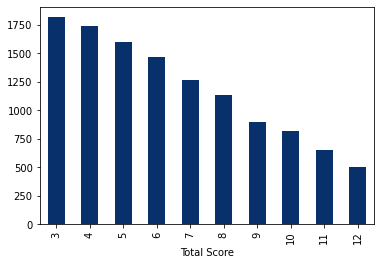

In [32]:


rfmSeg.groupby('Total Score').agg('monetary_value').mean().plot(kind='bar', colormap='Blues_r')



<AxesSubplot:xlabel='Total Score'>

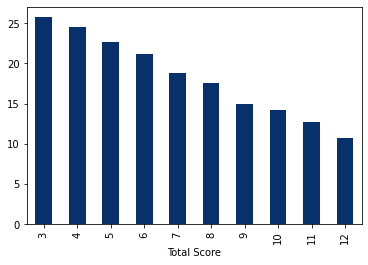

In [33]:


rfmSeg.groupby('Total Score').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')



<AxesSubplot:xlabel='Total Score'>

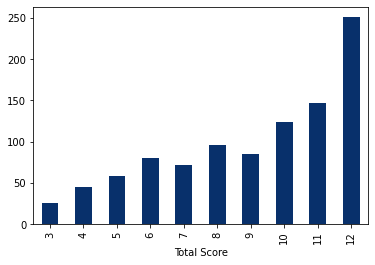

In [34]:


rfmSeg.groupby('Total Score').agg('recency').mean().plot(kind='bar', colormap='Blues_r')



Ultimate test of RFM score is the impact on any consumer behaviour. Let's check its impact on the response of customers to a promotion campaign.

In [38]:

res = pd.read_csv(r'C:\Users\Amol Tare\Desktop\Retail_Data_Response.csv')
res.sort_values('customer_id', inplace=True)

print(res.head(), res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB
  customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1 None


In [39]:
rfmSeg.reset_index(inplace=True)
rfmSeg.head()

,index,customer_id,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Score
0,0,CS1112,77.0,15,1012,3,3,3,333,9
1,1,CS1113,51.0,20,1490,2,2,2,222,6
2,2,CS1114,48.0,19,1432,2,2,2,222,6
3,3,CS1115,27.0,22,1659,1,2,1,121,4
4,4,CS1116,219.0,13,857,4,4,3,443,11


In [40]:
rfmSeg.sort_values('customer_id', inplace=True)
rfm2=pd.merge(rfmSeg, res, on='customer_id')

In [41]:
rfm2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 0 to 6883
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6884 non-null   int64  
 1   customer_id     6884 non-null   object 
 2   recency         6884 non-null   float64
 3   frequency       6884 non-null   int64  
 4   monetary_value  6884 non-null   int64  
 5   R_Quartile      6884 non-null   int64  
 6   F_Quartile      6884 non-null   int64  
 7   M_Quartile      6884 non-null   int64  
 8   RFMClass        6884 non-null   object 
 9   Total Score     6884 non-null   int64  
 10  response        6884 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 645.4+ KB


Text(0, 0.5, 'Proportion of Responders')

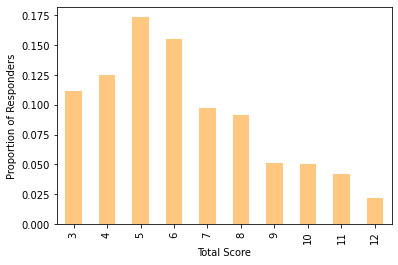

In [42]:
ax=rfm2.groupby('Total Score').agg('response').mean().plot(kind='bar', colormap='copper_r')
ax.set_xlabel("Total Score")
ax.set_ylabel("Proportion of Responders")
